In [1]:
# Standard Python libraries
import warnings
import numpy as np

# PySpark related imports
from pyspark.sql.functions import col, explode, desc, size
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.feature import StringIndexer, Word2Vec, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer

# PyTorch related imports
from torch import nn, optim, Tensor
import torch
from torch.utils.data import DataLoader, TensorDataset
from pyspark.ml.feature import Tokenizer

# Scikit-learn related imports
from sklearn.metrics import accuracy_score, classification_report

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Other imports
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# sc master running locally
sc.master

# Filter warnings
warnings.filterwarnings("ignore")

sc = spark.sparkContext

In [3]:
path = "/user1/Suicide_Detection.csv"
df = spark.read.csv(path)

In [4]:
# The inferred schema can be visualized using the printSchema() method
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



In [5]:
# Rename the columns
df = df.withColumnRenamed('_c0', 'ID')      # Rename _c0 to ID
df = df.withColumnRenamed('_c1', 'Text')    # Rename _c1 to Text
df = df.withColumnRenamed('_c2', 'Label')   # Rename _c2 to Label

# Show the DataFrame with renamed columns
df.show(5)

+----+--------------------+-----------+
|  ID|                Text|      Label|
+----+--------------------+-----------+
|null|                text|      class|
|   2|Ex Wife Threateni...|    suicide|
|   3|Am I weird I don'...|non-suicide|
|   4|"Finally 2020 is ...|non-suicide|
|   8|i need helpjust h...|    suicide|
+----+--------------------+-----------+
only showing top 5 rows



In [6]:
# Count Rows
row_count = df.count()
print("Total Rows:", row_count)

# Get Schema
df.printSchema()

Total Rows: 664905
root
 |-- ID: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label: string (nullable = true)



In [7]:
# "ID" column datatype changing
df = df.withColumn("ID", col("ID").cast("integer"))

In [8]:
# Remove rows with null values in any column
df = df.na.drop()

In [9]:
# Filter the DataFrame to include only 'suicide' and 'non-suicide' labels
df = df.filter((col('Label') == 'suicide') | (col('Label') == 'non-suicide'))

# Show the resulting DataFrame
df.show()

+---+--------------------+-----------+
| ID|                Text|      Label|
+---+--------------------+-----------+
|  2|Ex Wife Threateni...|    suicide|
|  3|Am I weird I don'...|non-suicide|
|  4|"Finally 2020 is ...|non-suicide|
|  8|i need helpjust h...|    suicide|
| 18|My life is over a...|    suicide|
| 19|I took the rest o...|    suicide|
| 21|Do you think gett...|    suicide|
| 23|Been arrested - f...|    suicide|
| 24|Fuck the verizon ...|non-suicide|
| 31|Me: I know I have...|non-suicide|
| 37|Guys I want frien...|non-suicide|
| 39|I’m trashLol I no...|    suicide|
| 41|What is the best ...|    suicide|
| 43|Today's fact is R...|non-suicide|
| 44|I feel like I am ...|    suicide|
| 45|Is it worth it?Is...|    suicide|
| 47|I triple nipple d...|non-suicide|
| 54|Hey, im gonna sle...|non-suicide|
| 57|I learnt a new sk...|non-suicide|
| 62|Why does no one u...|non-suicide|
+---+--------------------+-----------+
only showing top 20 rows



In [10]:
# 'Label' is the column of interest
label_counts = df.groupBy("Label").count().orderBy(col("count").desc())

# Show the label counts
label_counts.show()

+-----------+-----+
|      Label|count|
+-----------+-----+
|non-suicide|76506|
|    suicide|53612|
+-----------+-----+



In [11]:
df.show(2, truncate=False)

+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|ID |Text                                                                                                                                                                                                                                                                 

In [12]:
# Create a Tokenizer object
tokenizer = Tokenizer(inputCol="Text", outputCol="tokens")

# Tokenize the "processed_text" column
df = tokenizer.transform(df)

# Show the result
df.show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
# Show the "tokens" column
token_df = df.select("tokens")

token_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
df.show(5, truncate=True)

+---+--------------------+-----------+--------------------+
| ID|                Text|      Label|              tokens|
+---+--------------------+-----------+--------------------+
|  2|Ex Wife Threateni...|    suicide|[ex, wife, threat...|
|  3|Am I weird I don'...|non-suicide|[am, i, weird, i,...|
|  4|"Finally 2020 is ...|non-suicide|["finally, 2020, ...|
|  8|i need helpjust h...|    suicide|[i, need, helpjus...|
| 18|My life is over a...|    suicide|[my, life, is, ov...|
+---+--------------------+-----------+--------------------+
only showing top 5 rows



In [15]:
# Explode the tokens into separate rows
counting_df = df.withColumn("word", explode(df["tokens"]))

# Group by words and count their occurrences
word_counts = counting_df.groupBy("word").count()

# Order the word counts in descending order
word_counts = word_counts.orderBy(desc("count"))

# Select the top 20 words
top_20_words = word_counts.limit(20)

In [16]:
# Show the top 20 words and their counts
top_20_words.show(20)

+----+------+
|word| count|
+----+------+
|   i|476118|
|  to|277623|
| and|236422|
| the|167139|
|  my|165837|
|   a|164026|
|  of|106558|
|  it| 87695|
|  me| 85530|
|just| 83531|
|  is| 79251|
|  in| 78412|
| but| 77786|
|that| 72752|
|have| 72492|
| for| 70323|
|  so| 66496|
|this| 57312|
|like| 54352|
| i'm| 53014|
+----+------+



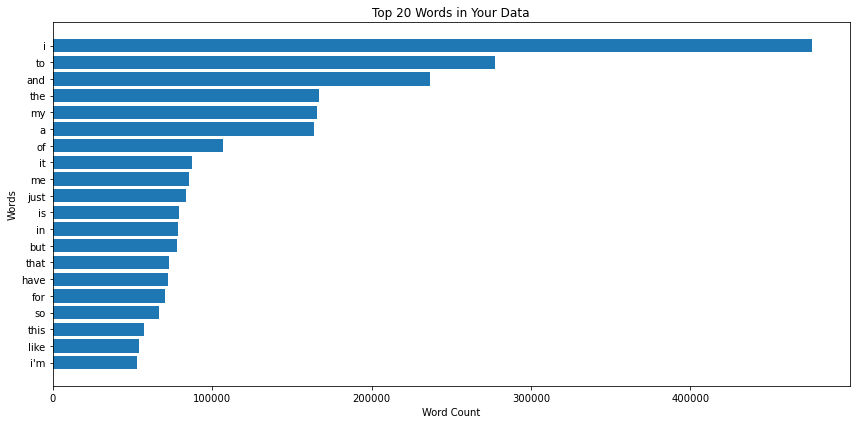

In [17]:
# Extract the word and count columns from the DataFrame
words = [row['word'] for row in top_20_words.collect()]
counts = [row['count'] for row in top_20_words.collect()]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, counts)
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.title('Top 20 Words in Your Data')
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent word at the top
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [19]:
# Define the maximum sequence length you want
max_sequence_length = 50

# Define a function to pad sequences
def pad_sequence(tokens, length):
    return tokens + [""] * (length - len(tokens))

# Create a UDF to apply the padding function
pad_udf = F.udf(lambda tokens: pad_sequence(tokens, max_sequence_length), T.ArrayType(T.StringType()))

# Apply the UDF to pad the sequences
df = df.withColumn("padded_tokens", pad_udf(df["tokens"]))

# Select the relevant columns: ID, padded_tokens, and Label
final_df = df.select("ID", "padded_tokens", "Label")

# Show the resulting DataFrame
final_df.show(5, truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
final_df.show(5, truncate=True)

+---+--------------------+-----------+
| ID|       padded_tokens|      Label|
+---+--------------------+-----------+
|  2|[ex, wife, threat...|    suicide|
|  3|[am, i, weird, i,...|non-suicide|
|  4|["finally, 2020, ...|non-suicide|
|  8|[i, need, helpjus...|    suicide|
| 18|[my, life, is, ov...|    suicide|
+---+--------------------+-----------+
only showing top 5 rows



In [21]:
# Initialize the StringIndexer
label_indexer = StringIndexer(inputCol="Label", outputCol="LabelIndex")

# Fit the StringIndexer on your DataFrame
indexed_df = label_indexer.fit(df).transform(df)

# Show the resulting DataFrame
indexed_df.show(2, truncate=True)

+---+--------------------+-----------+--------------------+--------------------+----------+
| ID|                Text|      Label|              tokens|       padded_tokens|LabelIndex|
+---+--------------------+-----------+--------------------+--------------------+----------+
|  2|Ex Wife Threateni...|    suicide|[ex, wife, threat...|[ex, wife, threat...|       1.0|
|  3|Am I weird I don'...|non-suicide|[am, i, weird, i,...|[am, i, weird, i,...|       0.0|
+---+--------------------+-----------+--------------------+--------------------+----------+
only showing top 2 rows



In [22]:
# Define Word2Vec parameters
word2vec = Word2Vec(
    vectorSize=100,       # Set the size of the word vectors
    seed=42,              # Set a seed for reproducibility
    inputCol="padded_tokens",  # Specify the input column with your tokenized and padded text
    outputCol="word_vectors"   # Specify the output column for word vectors
)

In [23]:
# Train the Word2Vec model
word2vec_model = word2vec.fit(indexed_df)

In [24]:
# Transform the DataFrame to include word vectors
df = word2vec_model.transform(indexed_df)

In [25]:
df.show(1, truncate=True)

+---+--------------------+-------+--------------------+--------------------+----------+--------------------+
| ID|                Text|  Label|              tokens|       padded_tokens|LabelIndex|        word_vectors|
+---+--------------------+-------+--------------------+--------------------+----------+--------------------+
|  2|Ex Wife Threateni...|suicide|[ex, wife, threat...|[ex, wife, threat...|       1.0|[0.15129990431958...|
+---+--------------------+-------+--------------------+--------------------+----------+--------------------+
only showing top 1 row



In [26]:
# Initialize the StandardScaler
scaler = StandardScaler(inputCol="word_vectors", outputCol="scaled_word_vectors", withMean=True, withStd=True)

In [27]:
# Create a Pipeline to apply the scaler
pipeline = Pipeline(stages=[scaler])

In [28]:
# Fit and transform the DataFrame using the pipeline
scaled_df = pipeline.fit(df).transform(df)

In [29]:
scaled_df.show(5, truncate=True)

+---+--------------------+-----------+--------------------+--------------------+----------+--------------------+--------------------+
| ID|                Text|      Label|              tokens|       padded_tokens|LabelIndex|        word_vectors| scaled_word_vectors|
+---+--------------------+-----------+--------------------+--------------------+----------+--------------------+--------------------+
|  2|Ex Wife Threateni...|    suicide|[ex, wife, threat...|[ex, wife, threat...|       1.0|[0.15129990431958...|[1.20124083637301...|
|  3|Am I weird I don'...|non-suicide|[am, i, weird, i,...|[am, i, weird, i,...|       0.0|[-0.0481562759727...|[-0.1914851304084...|
|  4|"Finally 2020 is ...|non-suicide|["finally, 2020, ...|["finally, 2020, ...|       0.0|[-0.0920528553985...|[-0.4979980994705...|
|  8|i need helpjust h...|    suicide|[i, need, helpjus...|[i, need, helpjus...|       1.0|[-0.1856799309793...|[-1.1517600393823...|
| 18|My life is over a...|    suicide|[my, life, is, ov...|[my

In [30]:
scaled_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- padded_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LabelIndex: double (nullable = false)
 |-- word_vectors: vector (nullable = true)
 |-- scaled_word_vectors: vector (nullable = true)



In [31]:
# Extract relevant columns
scaled_word_vectors = scaled_df.select("scaled_word_vectors").rdd.flatMap(lambda x: x).collect()
labels = scaled_df.select("LabelIndex").rdd.flatMap(lambda x: x).collect()

In [32]:
# Convert scaled_word_vectors to NumPy array
X = np.array(scaled_word_vectors)

In [33]:
# Convert labels to NumPy array
y = np.array(labels)

In [34]:
# Split data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Convert NumPy arrays to PyTorch tensors for training and validation sets
X_train = torch.tensor(X_train, dtype=torch.float32)
X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)

In [36]:
# Define the RNN model using PyTorch
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

In [37]:
# Model configuration
input_size = X_train.shape[1]
hidden_size = 100
output_size = 1  # Binary classification
model = RNNModel(input_size, hidden_size, output_size)

In [38]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Training parameters
num_epochs, batch_size, verbose = 20, 32, 1

In [40]:
# Prepare DataLoaders for training and validation
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(X_validation.unsqueeze(1), y_validation)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [41]:
# Initialize lists to store training and validation losses
train_losses = []       # List to store training losses
validation_losses = []  # List to store validation losses
train_accuracies = []   # List to store training accuracies
validation_accuracies = []  # List to store validation accuracies

In [42]:
for epoch in range(num_epochs):
    train_total_loss, train_correct_predictions = 0.0, 0
    validation_total_loss, validation_correct_predictions = 0.0, 0

    # Training loop
    model.train()  # Set the model in training mode
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        train_total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        train_correct_predictions += (predicted.squeeze() == labels).sum().item()
    
    average_train_loss = train_total_loss / len(train_loader)
    train_accuracy = train_correct_predictions / len(train_dataset)
    
    train_losses.append(average_train_loss)  # Append training loss for this epoch
    train_accuracies.append(train_accuracy)  # Append training accuracy for this epoch
    
    if verbose:
        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {average_train_loss}, Training Accuracy: {train_accuracy}")
    
    # Validation loop
    model.eval()  # Set the model in evaluation mode
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            validation_total_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            validation_correct_predictions += (predicted.squeeze() == labels).sum().item()
    
    average_validation_loss = validation_total_loss / len(validation_loader)
    validation_accuracy = validation_correct_predictions / len(validation_dataset)
    
    validation_losses.append(average_validation_loss)  # Append validation loss for this epoch
    validation_accuracies.append(validation_accuracy)  # Append validation accuracy for this epoch
    
    if verbose:
        print(f"Epoch {epoch + 1}/{num_epochs}: Validation Loss: {average_validation_loss}, Validation Accuracy: {validation_accuracy}")

Epoch 1/20: Training Loss: 0.2653946384576845, Training Accuracy: 0.8924625818971315
Epoch 1/20: Validation Loss: 0.23061785503938173, Validation Accuracy: 0.9083922533046419
Epoch 2/20: Training Loss: 0.23593121435856254, Training Accuracy: 0.9057486502584203
Epoch 2/20: Validation Loss: 0.22437751514228468, Validation Accuracy: 0.9103135567168767
Epoch 3/20: Training Loss: 0.22655495889816987, Training Accuracy: 0.9099563855745768
Epoch 3/20: Validation Loss: 0.21259304243357308, Validation Accuracy: 0.9156547802028896
Epoch 4/20: Training Loss: 0.22105317463416377, Training Accuracy: 0.9116951985705228
Epoch 4/20: Validation Loss: 0.2119484005646931, Validation Accuracy: 0.9145788502920381
Epoch 5/20: Training Loss: 0.2162323368348518, Training Accuracy: 0.9141449074874632
Epoch 5/20: Validation Loss: 0.22092986179868113, Validation Accuracy: 0.912426990470335
Epoch 6/20: Training Loss: 0.21253393135181564, Training Accuracy: 0.9159509673948546
Epoch 6/20: Validation Loss: 0.2054433

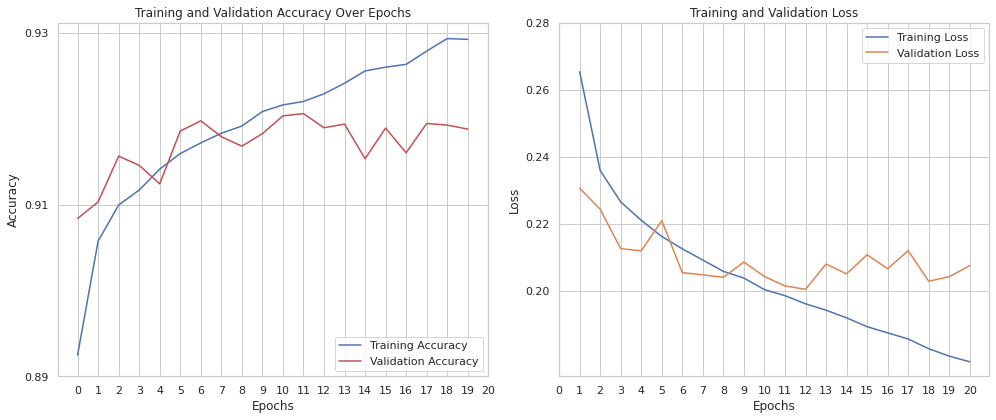

In [43]:
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation accuracy
for data, label, color in [(train_accuracies, 'Training Accuracy', 'b'), (validation_accuracies, 'Validation Accuracy', 'r')]:
    ax1.plot(data, label=label, color=color)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy Over Epochs')
ax1.legend(loc='lower right')

# Set Y-axis ticks starting from 0.20 to 0.3 with increments of 0.05
ax1.set_yticks([0.89 + 0.02 * i for i in range(3)])
ax1.set_xticks([0 + 1 * i for i in range(21)])

# Plot training and validation loss
epochs = range(1, num_epochs + 1)
for data, label in [(train_losses, 'Training Loss'), (validation_losses, 'Validation Loss')]:
    ax2.plot(epochs, data, label=label)

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True)

# Set Y-axis and X-axis ticks starting from 0.20 to 0.3 with increments of 0.05
ax2.set_yticks([0.20 + 0.02 * i for i in range(5)])
ax2.set_xticks([0 + 1 * i for i in range(21)])

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [44]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Create a test dataset using your X_test and y_test
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

In [46]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Set the model in evaluation mode
model.eval()

# Initialize lists to store test losses and correct predictions
test_losses = []
correct_predictions = 0

# Testing the Model and Calculating Metrics with PyTorch
with torch.no_grad():
    for inputs, labels in test_loader:
        # Reshape inputs to match the model's input requirements
        inputs = inputs.unsqueeze(1)  # Add a sequence length dimension
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate test loss
        test_loss = criterion(outputs.squeeze(), labels)
        test_losses.append(test_loss.item())
        
        # Calculate predictions and accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted.squeeze() == labels).sum().item()
        
        # Append true labels and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [47]:
# Calculate average test loss and accuracy
test_average_loss = sum(test_losses) / len(test_losses)
test_accuracy = correct_predictions / len(test_dataset)

In [48]:
# Print test results and confusion matrix
print(f"Test Loss: {test_average_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.20752708262624334, Test Accuracy: 0.9188057177989548


In [49]:
# Pandas dataframe just for the create a manual dataset and make prediction
import pandas as pd

# Manually create a list of text samples
text_samples = [
    "I'm feeling really down today. I can't take it anymore.",
    "Had a great day at the park with my friends!",
    "Life is so hard, and I don't see a way out.",
    "Just got a promotion at work! Feeling on top of the world!",
]

# Create a DataFrame with the text samples
manual_df = spark.createDataFrame([(text,) for text in text_samples], ["Text"])

# Show the DataFrame
manual_df.show()

+--------------------+
|                Text|
+--------------------+
|I'm feeling reall...|
|Had a great day a...|
|Life is so hard, ...|
|Just got a promot...|
+--------------------+



In [50]:
# Create another DataFrame with labels to compare after the prediction.
# This dataset has not seen by the model. It's just for visualisation
labels = ["suicide", "non-suicide", "suicide", "non-suicide"]

data = {
    "Text": text_samples,
    "Label": labels
}

labeled_df = pd.DataFrame(data)

print(labeled_df)

                                                Text        Label
0  I'm feeling really down today. I can't take it...      suicide
1       Had a great day at the park with my friends!  non-suicide
2        Life is so hard, and I don't see a way out.      suicide
3  Just got a promotion at work! Feeling on top o...  non-suicide


In [51]:
# Tokenize the "Text" column
manual_df = tokenizer.transform(manual_df)

# Apply padding to the sequences
manual_df = manual_df.withColumn("padded_tokens", pad_udf(manual_df["tokens"]))

# Show the preprocessed DataFrame
manual_df.show(truncate=False)

+----------------------------------------------------------+-----------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+
|Text                                                      |tokens                                                                 |padded_tokens                                                                                                                                      |
+----------------------------------------------------------+-----------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+
|I'm feeling really down today. I can't take it anymore.   |[i'm, feeling, really, down, today., i, can't, take, it, anymore.]     |[i'm, feeling, really, do

In [52]:
# Transform the DataFrame to include word vectors
manual_df = word2vec_model.transform(manual_df)

# Apply scaling
scaled_manual_df = pipeline.fit(manual_df).transform(manual_df)

# Extract relevant columns
scaled_word_vectors_manual = scaled_manual_df.select("scaled_word_vectors").rdd.flatMap(lambda x: x).collect()

# Convert scaled_word_vectors to NumPy array
X_manual = np.array(scaled_word_vectors_manual)

# Convert NumPy array to PyTorch tensor
X_manual = torch.tensor(X_manual, dtype=torch.float32)

# Set the model in evaluation mode
model.eval()

# Initialize lists to store predicted labels
predicted_labels_manual = []

# Make predictions on the manual dataset
with torch.no_grad():
    for inputs in X_manual:
        # Reshape inputs to match the model's input requirements
        inputs = inputs.unsqueeze(0).unsqueeze(0)  # Add batch and sequence length dimensions
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        predicted_labels_manual.append(predicted.item())

# Print the predicted labels
print("Predicted Labels for Manual Dataset:")
for text, label in zip(text_samples, predicted_labels_manual):
    print(f"Text: '{text}' - Predicted Label: {'suicide' if label == 1 else 'non-suicide'}")

Predicted Labels for Manual Dataset:
Text: 'I'm feeling really down today. I can't take it anymore.' - Predicted Label: suicide
Text: 'Had a great day at the park with my friends!' - Predicted Label: non-suicide
Text: 'Life is so hard, and I don't see a way out.' - Predicted Label: suicide
Text: 'Just got a promotion at work! Feeling on top of the world!' - Predicted Label: non-suicide


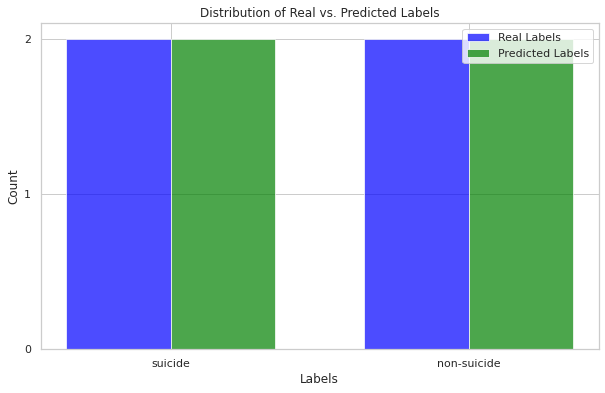

In [53]:
# Count the occurrences of each label in both DataFrames
real_label_counts = labeled_df["Label"].value_counts()

# Calculate the counts of predicted labels manually
predicted_label_counts = [predicted_labels_manual.count(1), predicted_labels_manual.count(0)]

# Create a bar plot to compare the distributions
labels = ["suicide", "non-suicide"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, real_label_counts, width, label='Real Labels', color='blue', alpha=0.7)
plt.bar(x + width/2, predicted_label_counts, width, label='Predicted Labels', color='green', alpha=0.7)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Real vs. Predicted Labels')
plt.xticks(x, labels)
plt.legend()
plt.yticks([0, 1, 2])

plt.show()

In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors for training and validation sets
X_train = torch.tensor(X_train, dtype=torch.float32)
X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)

# Define the Simple RNN model using PyTorch
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Add a batch dimension if it's missing
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last RNN output
        return out

# Model configuration
input_size = X_train.shape[-1]  # Use the last dimension as input size
hidden_size = 100
output_size = 1  # Binary classification
model = SimpleRNNModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20
batch_size = 32

# Initialize lists to store training and validation losses, accuracies
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Append training loss
    train_losses.append(loss.item())

    # Evaluation on validation data
    model.eval()  # Set the model in evaluation mode
    with torch.no_grad():
        # Forward pass on validation data
        val_outputs = model(X_validation)
        val_loss = criterion(val_outputs.squeeze(), y_validation)
        validation_losses.append(val_loss.item())

        # Calculate accuracy on training and validation data
        train_predictions = (torch.sigmoid(outputs) > 0.5).float()
        val_predictions = (torch.sigmoid(val_outputs) > 0.5).float()
        train_accuracy = accuracy_score(y_train.numpy(), train_predictions.numpy())
        val_accuracy = accuracy_score(y_validation.numpy(), val_predictions.numpy())
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

# Print final results
print("Final Results:")
print(f"Training Loss: {train_losses[-1]}, Validation Loss: {validation_losses[-1]}, Training Accuracy: {train_accuracies[-1]}, Validation Accuracy: {validation_accuracies[-1]}")

Epoch 1/20, Training Loss: 0.7409895062446594, Validation Loss: 0.6700261831283569, Training Accuracy: 0.31812592464503237, Validation Accuracy: 0.640101444820166
Epoch 2/20, Training Loss: 0.6707879900932312, Validation Loss: 0.6210072636604309, Training Accuracy: 0.6388744788364363, Validation Accuracy: 0.700122963418383
Epoch 3/20, Training Loss: 0.6230310797691345, Validation Loss: 0.5917002558708191, Training Accuracy: 0.6970910907449036, Validation Accuracy: 0.7077313249308331
Epoch 4/20, Training Loss: 0.594944953918457, Validation Loss: 0.5770169496536255, Training Accuracy: 0.7036332545583799, Validation Accuracy: 0.7116892099600369
Epoch 5/20, Training Loss: 0.5813797116279602, Validation Loss: 0.5711174011230469, Training Accuracy: 0.7070724537437316, Validation Accuracy: 0.7139947740547187
Epoch 6/20, Training Loss: 0.5764418840408325, Validation Loss: 0.5689976215362549, Training Accuracy: 0.7094645224508617, Validation Accuracy: 0.7166461727636029
Epoch 7/20, Training Los

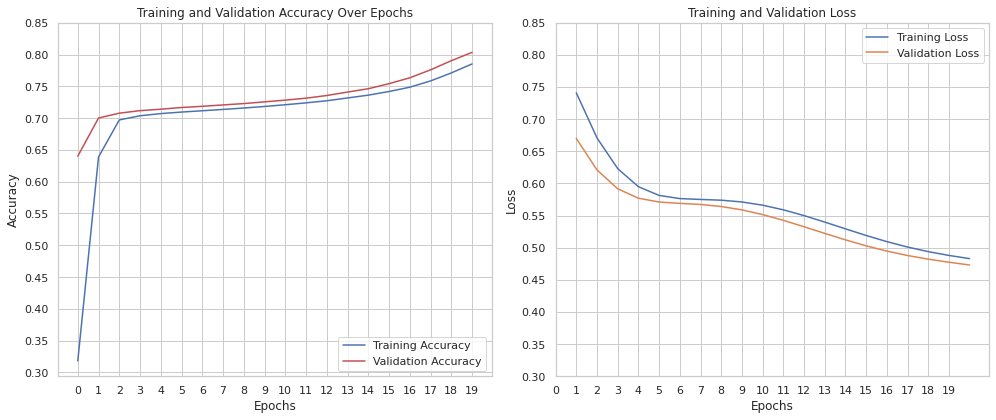

In [69]:
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation accuracy
for data, label, color in [(train_accuracies, 'Training Accuracy', 'b'), (validation_accuracies, 'Validation Accuracy', 'r')]:
    ax1.plot(data, label=label, color=color)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy Over Epochs')
ax1.legend(loc='lower right')
ax1.grid(True)

# Set Y-axis ticks starting from 0.20 to 0.3 with increments of 0.05
ax1.set_yticks([0.30 + 0.05 * i for i in range(12)])
ax1.set_xticks([1 * i for i in range(20)])

# Plot training and validation loss
epochs = range(1, num_epochs + 1)
for data, label in [(train_losses, 'Training Loss'), (validation_losses, 'Validation Loss')]:
    ax2.plot(epochs, data, label=label)

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True)

# Set Y-axis and X-axis ticks starting from 0.20 to 0.3 with increments of 0.05
ax2.set_yticks([0.30 + 0.05 * i for i in range(12)])
ax2.set_xticks([1 * i for i in range(20)])

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()